In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.models import Client, SimulationAlchemy as Simulation
from tools.gamma_estimator import Engine

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging
import sys, os
from settings import DFS_PATH
from utils.utils import plot_mean_std, delete_dfs, smoothen, concat, df_round_time
import scipy.optimize

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [2]:
items = client.get_simulation_groups(["ER 3.600.weak.lammps"] )[:200]
# [item.load_df() for item in tqdm(items)];

./scripts/precalc_acs/submit_job.py --group-name="ER 3.35.lammps" --shift=5000 --wide=1000 --dt1=100 --dt2=500 --W=500

In [3]:
item = items[0]
potential_a = 0.5*(1/item.a+1/item.b)
wide = 1000
shift = 5000

In [4]:
def parallel_step(item, progress=False):
    engine = Engine(item, shift, wide)
#     engine.load_vc()
#     engine.generate_time_points(dt1, dt2)
#     engine.calc_acs(progress=progress)
#     engine.delete_vc()
    engine.load(acs=True)
    return engine
engines = [parallel_step(item) for item in tqdm(items[:])]
engine = engines[0]

  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
def f(engine):
    return [
    engine._get_gamma(W=5, estimators=[engine.gamma_3], prefix="5/"),
    engine._get_gamma(W=15, estimators=[engine.gamma_3], prefix="15/"),
    engine._get_gamma(W=30, estimators=[engine.gamma_3], prefix="30/"),
    engine._get_gamma(W=50, estimators=[engine.gamma_3], prefix="50/") ,  
    engine._get_gamma(W=50, estimators=[engine.gamma_3], prefix="70/") ,
    engine._get_gamma(W=50, estimators=[engine.gamma_3], prefix="90/") ,  
    engine._get_gamma(W=100, estimators=[engine.gamma_3], prefix="100/"),   
    engine._get_gamma(W=200, estimators=[engine.gamma_3], prefix="200/") ,  
#     engine._get_gamma(W=500, estimators=[engine.gamma_3], prefix="500/"),
    ]

In [13]:
pool.close()
# del pool

In [6]:
from multiprocessing import Pool, cpu_count, get_context

# pool = get_context("spawn").Pool(cpu_count())
pool = Pool(cpu_count())

In [7]:
res_generator = pool.imap(f, engines)
gamma_data = list(tqdm(res_generator, total=len(engines)))

  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
for engine, res in zip(engines, gamma_data):
    for subres in res:
        engine._apply_data(subres)

In [9]:
frames = [pd.DataFrame(engine.data).set_index("t") for engine in engines]
frames = [frame for frame in frames if "g1" in frame]

print(len(frames))

200


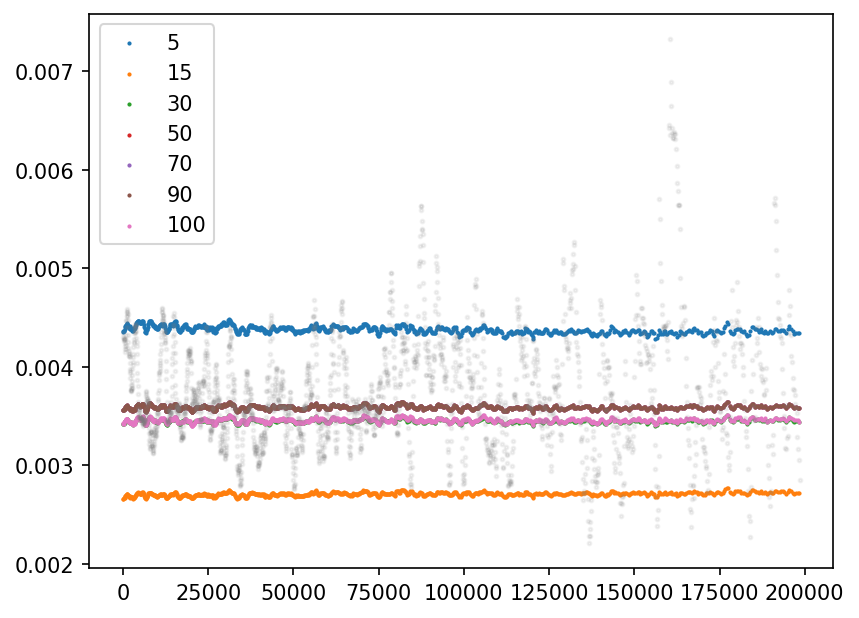

In [15]:
df_mathematica = pd.read_csv("/home/ashmat/Desktop/ashmat/mathematica_exports/ERlong-523-0.0374-205000-(1560).h5.csv", 
                             header=None).set_axis(["time","noneq", "_", "quasieq"], axis=1)

# sr = concat(frames, "g1", round=None).mean(axis=1).loc[shift:]
# plt.scatter(sr.index-shift, sr.values, s=3)
# sr = concat(frames, "g2", round=None).mean(axis=1).loc[shift:]
# plt.scatter(sr.index-shift, sr.values, s=3)
for key in ["5/g3", "15/g3", "30/g3", "50/g3", "70/g3", "90/g3","100/g3"]:
    sr = concat(frames, key, round=None).mean(axis=1).loc[shift:]
    plt.scatter(sr.index-shift, sr.values, s=1, alpha=1, label=key[:-3])

plt.scatter(df_mathematica.time, df_mathematica.noneq, s=3, alpha=0.1)
# plt.scatter(df_mathematica.time, df_mathematica.quasieq, s=3, alpha=0.1)

plt.legend()

# plt.xscale("log")
# plt.yscale("log")
# plt.ylim(0.0001,0.015)

In [14]:
df_mathematica[df_mathematica.time>100000].noneq.mean()

0.0037918347934433874

In [33]:
engine.dt

0.2

In [34]:
frames[0]

,L,O,T,crit1,crit2,g1,g2,g3,5/g3,30/g3,50/g3,100/g3,200/g3,500/g3,15/g3
t,,,,,,,,,,,,,,,
1100.0,1979.557649,0.172469,0.115732,0.000173,0.000019,0.007645,0.006386,0.003141,0.005163,0.003165,0.003231,0.003209,0.003171,0.003141,0.002549
1200.2,1979.557649,0.172294,0.115964,0.000143,0.000035,0.007415,0.006379,0.003140,0.005062,0.003111,0.003185,0.003184,0.003189,0.003140,0.002521
1300.4,1979.557649,0.172159,0.116118,0.000117,0.000039,0.007259,0.006407,0.003159,0.005124,0.003138,0.003185,0.003178,0.003172,0.003159,0.002558
1400.6,1979.557649,0.172058,0.116264,0.000091,0.000033,0.007084,0.006354,0.003145,0.005057,0.003116,0.003181,0.003171,0.003129,0.003145,0.002533
1500.8,1979.557649,0.171977,0.116350,0.000069,0.000024,0.006900,0.006278,0.003109,0.005020,0.003065,0.003124,0.003127,0.003103,0.003109,0.002480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61316.0,4.362836,0.000486,0.333364,0.000035,0.000048,0.006927,0.007002,0.003268,0.005558,0.003665,0.003679,0.003564,0.003430,0.003268,0.003176
61769.0,-2.625971,-0.000306,0.333319,0.000056,0.000039,0.007487,0.007394,0.003453,0.005753,0.003816,0.003840,0.003714,0.003585,0.003453,0.003289
62227.6,-2.920072,-0.000339,0.333321,0.000089,0.000080,0.007331,0.007293,0.003297,0.005811,0.003876,0.003913,0.003797,0.003608,0.003297,0.003329


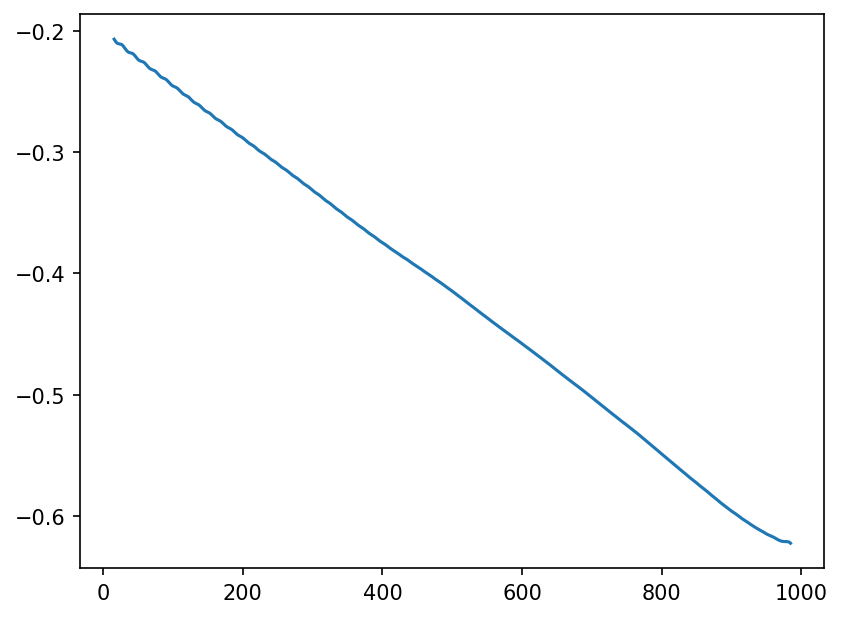

In [32]:
plt.plot(*engine._get_lac(engine.acs[5]))

In [ ]:
engine

In [10]:
engines[0].calc_gamma(100)

In [7]:
frames = [pd.DataFrame(engine.data) for engine in engines]

In [8]:
frames[0].head()

,L,O,T,t
0,1979.557649,0.180561,0.105493,220.0
1,1979.557649,0.177541,0.109334,320.2
2,1979.557649,0.175960,0.111363,420.4
3,1979.557649,0.175108,0.112370,520.6
4,1979.557649,0.174366,0.113404,620.8


In [ ]:
sr = concat(frames, "gamma", round=None).mean(axis=1).loc[shift:]
plt.scatter(sr.index-shift, sr.values, s=3)
sr = concat(frames, "gamma2", round=None).mean(axis=1).loc[shift:]
plt.scatter(sr.index-shift, sr.values, s=3)

plt.scatter(df_mathematica.time, df_mathematica.noneq, s=3)
plt.scatter(df_mathematica.time, df_mathematica.queq, s=3)

plt.xscale("log")
plt.yscale("log")
plt.ylim(0.0001,0.015)

In [4]:
item = items[0]
potential_a = 0.5*(1/item.a+1/item.b)
shift = 5000

In [45]:
import tools.gamma_estimator
importlib.reload(tools.gamma_estimator)
from tools.gamma_estimator import Engine

In [46]:
n_loaded = 2

In [47]:
def get_engine(item, progress=False):
    engine = Engine(item, shift, None)
    engine.load_vc()
#     engine.generate_time_points(dt1, dt2)
#     engine.calc_acs(progress=progress)
#     engine.delete_vc()
    return engine

In [48]:
engines = [get_engine(item) for item in tqdm(items[:n_loaded])]


  0%|          | 0/2 [00:00<?, ?it/s]

In [49]:
engine = engines[0]

In [52]:
engine.wide=200
print(len(engine.generate_time_points(100, 500)))
engine.calc_acs(progress=True)

346


  0%|          | 0/346 [00:00<?, ?it/s]

In [40]:
engine.wide = 199 + 0.000001
[( (engine._get_range(t)[1]-engine._get_range(t)[0])) for t in engine.time_points]

[995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995]

In [32]:
engine.wide=200+0.01
l, r = engine._get_range(2122.8)

In [33]:
r-l

1001

1212.0


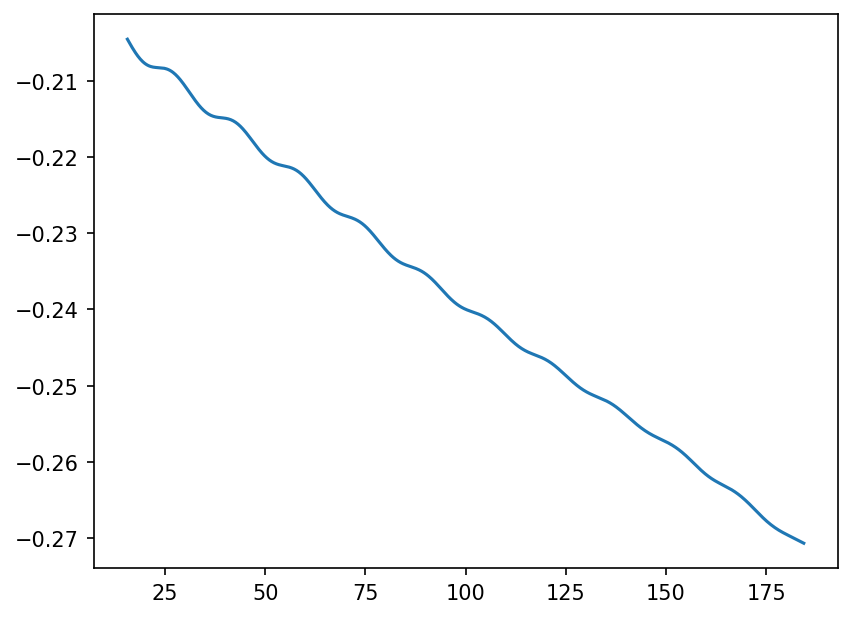

In [34]:
k = 10
print(engine.time_points[k])
# plt.plot(engine.ac_time, engine.acs[k])
plt.plot(*engine._get_lac(engine.acs[k]))

In [ ]:
plt.plot(en)

In [31]:
df_L = concat([item.df["L"] for item in items[:100]])

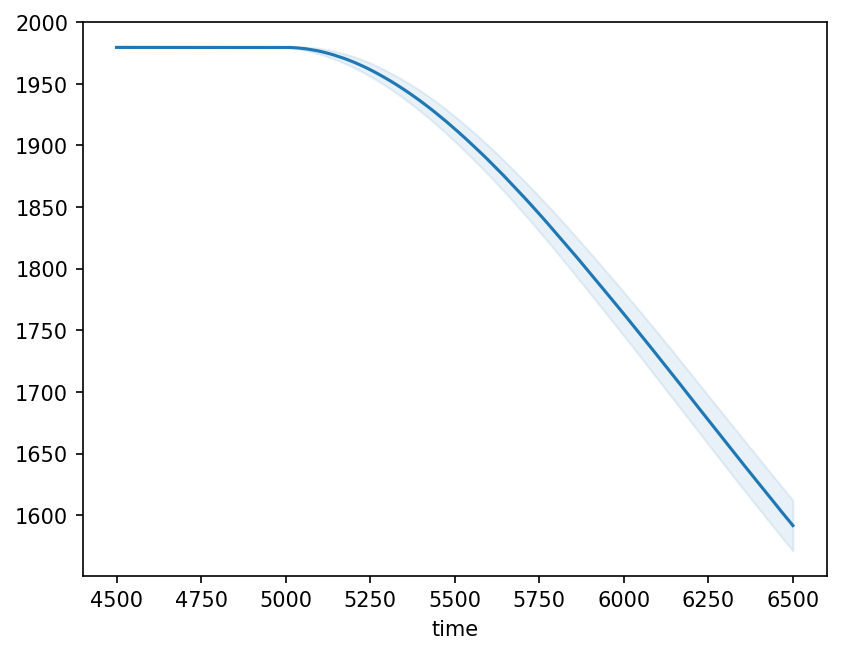

In [32]:
plot_mean_std(df_L.loc[4500:6500])

In [9]:
item.history["vs"].shape

(325001, 3, 523)

In [10]:
def AC(x):
    n = len(x)
    ac = np.correlate(x, x, "full")
    w = np.arange(n, 0, -1)
    ac = ac[n-1:] / w
    return ac

def get_subdf(df, t, wide):
    return df.loc[t-wide/2:t+wide/2]

def get_ac(item, t, wide):
    df = item.df
    df["i"] = range(len(df))
    
    subdf = get_subdf(df, t, wide)
    
    l,r = subdf.i.iloc[[0,-1]]
    
    
    vs = item.history["vs"][l:r+1]
    
    vc = vs[:,0] + 1j * vs[:,1]
    ac = []
    
#     vc = vc[l:r+1,:]
#     vc_relative = vc[l:r+1,:] * np.exp(-1j*subdf.omega_MLE.values.cumsum()*dt)[:,None]
#     ac = [AC(vc_relative[:,k]) for k in range(vc.shape[-1])]
    ac = [AC(vc[:,k]) for k in range(vc.shape[-1])]
    
    ac = np.stack(ac, axis=-1)
    return ac.mean(axis=-1)

In [11]:
%%timeit
get_ac(items[0], 1000,20)

7.42 ms ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
from utils.ACfunctions import Cr, Cv

def get_gamma(ac, T, O, a, W):
    ts = np.arange(len(ac))*dt
    
    def f(gamma, W):
        c = Cv(ts[:W], gamma, T, O, a)
        c1 = ac[:W]
        d = c-c1
        return np.real(d.dot(d.conj())) / len(d)
    
    def f2(gamma, W):
        c = Cv(ts[:W], gamma, T, O, a)
        c1 = ac[:W]
        c = c * (c1[0]/c[0])
        d = c-c1
        return np.real(d.dot(d.conj())) / len(d)
    
    
    
    optres = scipy.optimize.minimize(f, 1, args=(W,),bounds=[(0.0001, 10)])
    optres2 = scipy.optimize.minimize(f2, 1, args=(W,),bounds=[(0.0001, 10)])
    
    
    return {"crit": optres.fun, "gamma": optres.x[0],
            "crit2": optres2.fun, "gamma2": optres2.x[0]}

In [34]:
wide=400

In [35]:
time_points = [wide]

dt1 = 100
dt2 = 2000
beta = np.log(dt2/dt1)/(item.df.index[-1]-shift)

t = time_points = [wide]
while time_points[-1] < item.df.index[-1]-wide:
    t = time_points[-1]
    if t < shift:
        t += dt1
    else:
        t += dt1* np.exp(beta*(t-shift))
    time_points.append(t)

time_points = np.array(time_points[:-1])
# time_points = time_points[time_points>0.8*shift]

print(len(time_points))

238


In [36]:
def f(t, g, r):
    return np.exp(-g * t * (1+r))/(1+r)**2 + np.exp(-g * t * (1-r))/(1-r)**2

def get_ratio(ts, g, r):
    lac = np.log(f(ts, g, r))
    slope, _ = np.polyfit(ts, lac, 1)
    return slope/g

def fit_gamma(ac_sr, r, iterations=3):
    ts, ac = ac_sr.index.values, ac_sr.values
    lac = np.log(np.abs(ac))
    
    slope,_ = np.polyfit(ts, lac, 1)
    
    gamma = 0.01
    for _ in range(iterations):
        ratio = get_ratio(ts, gamma, r)
        gamma = -slope / ratio
        
    return gamma
    

In [29]:
acs[0].shape

(201,)

In [43]:
acs_df_avg

,0,1,2,3,4,5,6,7,8,9,...,228,229,230,231,232,233,234,235,236,237
20.0,0.798151,0.802771,0.804761,0.805492,0.805988,0.806477,0.807939,0.808875,0.809716,0.810996,...,0.377581,0.390767,0.388126,0.383484,0.381981,0.394805,0.391737,0.391264,0.393918,0.380836


In [38]:
frames = []

for item in tqdm_notebook(items[:n_loaded], disable=False):
    df = item.df

    acs = [get_ac(item, t, wide) for t in tqdm_notebook(time_points, disable=False)]
    ts = np.arange(len(acs[0])) * dt
    Ts = np.array([(get_subdf(df, t,wide)["beta_MLE"].values**-1).mean() for t in (time_points)])
    Os = np.array([get_subdf(df, t,wide)["omega_MLE"].values.mean() for t in (time_points)])
    Ls = np.array([get_subdf(df, t,wide)["L"].values.mean() for t in (time_points)])
    
    a = 0.5*(1/item.a+1/item.b)
    acs_df = pd.DataFrame(np.array([ac[:200] for ac in acs]).T).set_index(ts[:200])
    acs_df_avg = np.abs(acs_df.loc[:500]).rolling(int(40/dt),center=True).mean().dropna()
    
    frame = pd.DataFrame({
        "O": Os,
        "T": Ts,
        "L": Ls,
        "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
    }, index=time_points)

    frame = frame.join(pd.DataFrame([get_gamma(ac, T, O, a, 100) for ac, T, O in zip(acs, Ts, Os)], index=time_points))
    
    frames.append(frame)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_10141/3769177264.py:20: RankWarning: Polyfit may be poorly conditioned
  "g1": [fit_gamma(acs_df_avg[col].loc[:150], O/a) for col, O in zip(acs_df_avg.columns, Os)],
/data/biophys/ashmat/tmp/ipykernel_10141/4129636611.py:17: RankWarning: Polyfit may be poorly conditioned
  ratio = get_ratio(ts, gamma, r)
/data/biophys/ashmat/tmp/ipykernel_101

  0%|          | 0/238 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
df_mathematica = pd.read_csv("file.csv", header=None).set_axis(["time","noneq", "time_2","queq"], axis=1)

In [41]:
frames

[                     O         T            L        g1      crit     gamma  \
 400.000000    0.176693  0.110379  1979.557649 -0.000001  0.005483  0.229336   
 500.000000    0.175328  0.112131  1979.557649 -0.000001  0.003369  0.135299   
 600.000000    0.174462  0.113250  1979.557649 -0.000001  0.002228  0.087984   
 700.000000    0.173766  0.114076  1979.557649 -0.000002  0.001367  0.060252   
 800.000000    0.173088  0.114957  1979.557649 -0.000002  0.000706  0.039142   
 ...                ...       ...          ...       ...       ...       ...   
 57470.279452  0.004515  0.333261    40.281175 -0.040658  0.000039  0.005617   
 58843.552165  0.006873  0.333005    58.665395 -0.048324  0.000038  0.011498   
 60314.287773  0.005554  0.333149    48.347579 -0.045033  0.000001  0.008810   
 61897.086868 -0.000510  0.333478    -4.362822 -0.052359  0.000024  0.012205   
 63610.045775  0.000301  0.333254     2.568542 -0.053728  0.000042  0.012930   
 
                      crit2    gamma2 

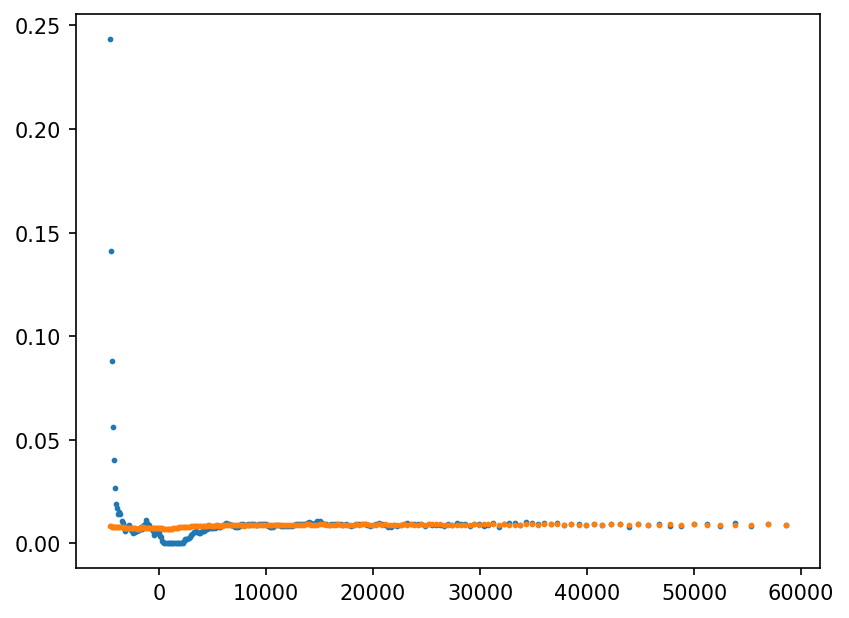

In [39]:
sr = concat(frames, "gamma", round=None).mean(axis=1).loc[:]
plt.scatter(sr.index-shift, sr.values, s=3)
sr = concat(frames, "gamma2", round=None).mean(axis=1).loc[:]
plt.scatter(sr.index-shift, sr.values, s=3)
# plt.ylim(0,0.1)

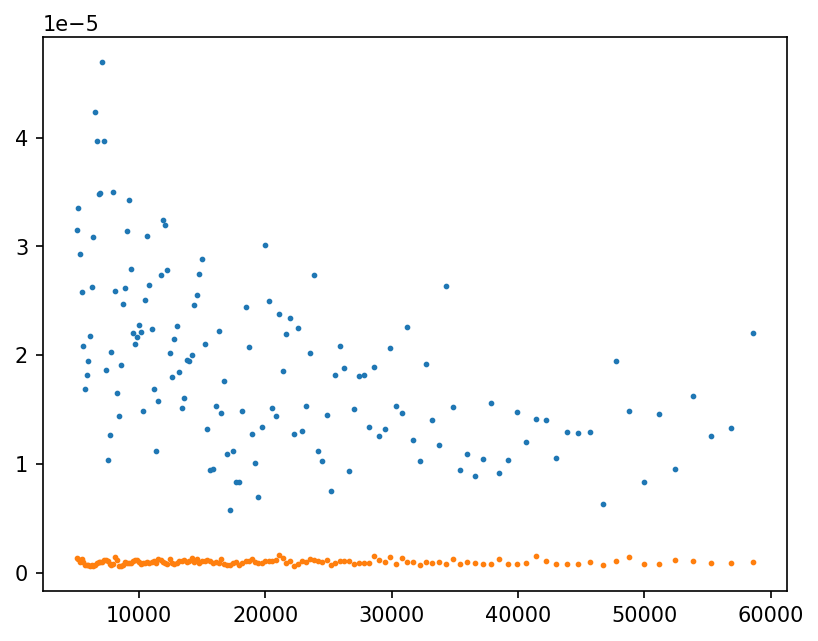

In [40]:
sr = concat(frames, "crit", round=None).mean(axis=1).loc[10000:]
plt.scatter(sr.index-shift, sr.values, s=3)
sr = concat(frames, "crit2", round=None).mean(axis=1).loc[10000:]
plt.scatter(sr.index-shift, sr.values, s=3)
# plt.ylim(0,0.1)

(0.0001, 0.015)

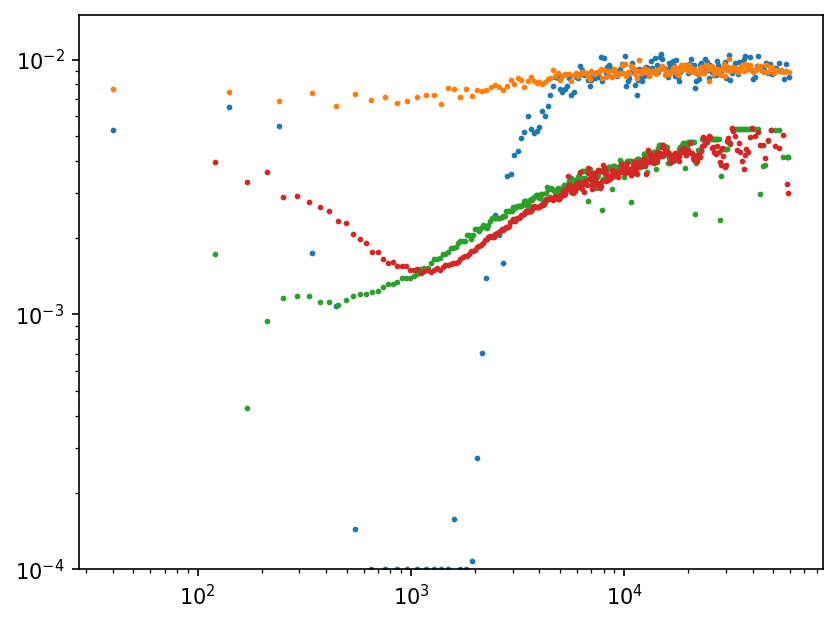

In [20]:
sr = concat(frames, "gamma", round=None).mean(axis=1).loc[shift:]
plt.scatter(sr.index-shift, sr.values, s=3)
sr = concat(frames, "gamma2", round=None).mean(axis=1).loc[shift:]
plt.scatter(sr.index-shift, sr.values, s=3)

plt.scatter(df_mathematica.time, df_mathematica.noneq, s=3)
plt.scatter(df_mathematica.time, df_mathematica.queq, s=3)

plt.xscale("log")
plt.yscale("log")
plt.ylim(0.0001,0.015)

159593.3525516605 0.008371400659833392


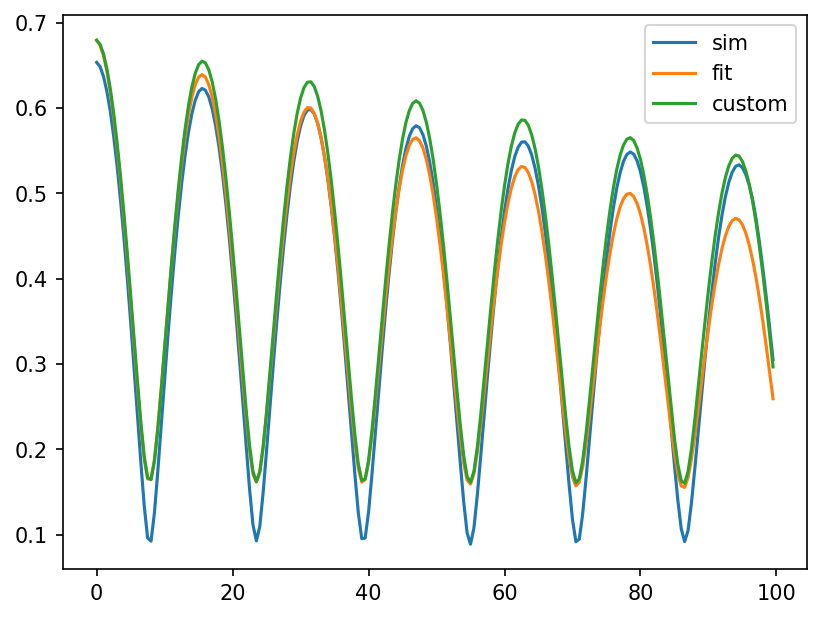

In [20]:
iac = 24
iac = 1000

ts = np.arange(len(acs[iac])) * dt
plt.plot(ts, np.abs(acs[iac]), label="sim")

line = frame.iloc[iac]
print(time_points[iac], line.gamma)
ac_theo = Cv(ts, line.gamma, line["T"], line.O,potential_a)
plt.plot(ts, np.abs(ac_theo), label="fit")
ac_theo = Cv(ts, 0.005, line["T"], line.O,potential_a)
plt.plot(ts, np.abs(ac_theo), label="custom")
plt.legend()

{'crit': 3.544288296290275e-06, 'gamma': 0.007733526335517205}

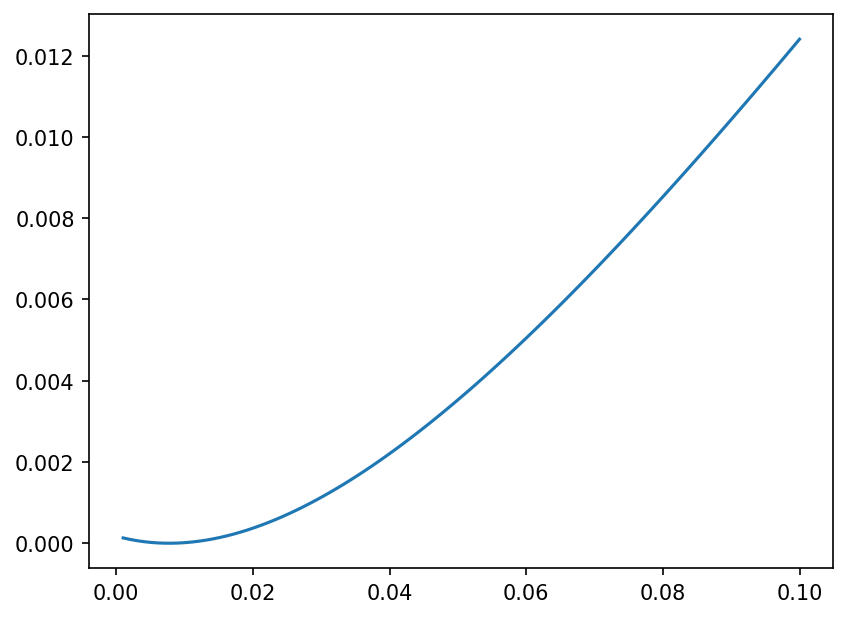

In [104]:
get_gamma_2(acs[iac], line["T"], line.O, potential_a, 100)

In [103]:
def get_gamma_2(ac, T, O, a, W):
    ts = np.arange(len(ac))*dt
    
    def f(gamma, W):
        c = Cv(ts[:W], gamma, T, O, a)
        c1 = ac[:W]
        
        c = c * (c1[0]/c[0])
        
        d = c-c1
        return np.real(d.dot(d.conj())) / len(d)
    
    def f2(gamma, W):

    #     W = 200
        c = Cv(ts[:W], gamma, T, O, a)
        c1 = ac[:W]
        
        c = c * (c1[0]/c[0])
        
        d = c-c1
        return np.real(d.dot(d.conj())) / len(d)
    
    gvals = np.linspace(0.000001, 0.1, 100)
    plt.plot(gvals, [f(g, W) for g in gvals])

    optres = scipy.optimize.minimize(f, 1, args=(W,), bounds=[(0.0001, 10)])
    return {"crit": optres.fun, "gamma": optres.x[0]}

<Axes: >

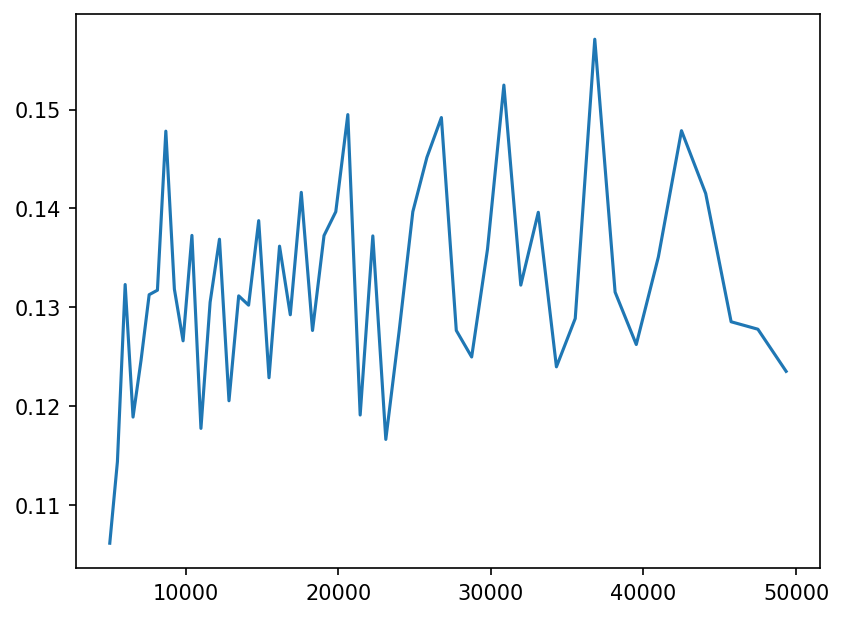

In [183]:
frame.loc[shift:].gamma.plot()

In [127]:
ts

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
       11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
       13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
       15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
       17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6,
       19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4, 21.6, 21.8,
       22. , 22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6, 23.8, 24. ,
       24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8, 26. , 26.2,
       26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. , 28.2, 28.4,
       28.6, 28.8, 29. , 29.2, 29.4, 29.6, 29.8, 30

In [135]:
frame

,O,T,L,crit,gamma
1000.000000,0.428290,0.117241,791.821225,0.000056,0.119050
1500.000000,0.428282,0.117244,791.821225,0.000017,0.118759
2000.000000,0.428191,0.117303,791.821227,0.000022,0.115105
2500.000000,0.428078,0.117346,791.821227,0.000029,0.111068
3000.000000,0.428451,0.117143,791.821225,0.000048,0.124831
3500.000000,0.428541,0.117118,791.821224,0.000021,0.125673
4000.000000,0.428526,0.117135,791.821224,0.000052,0.118791
4500.000000,0.428285,0.117235,791.821226,0.000008,0.122719
5000.000000,0.417996,0.129025,765.829434,0.000463,0.073156
5500.000000,0.390512,0.160750,690.036905,0.004088,0.032476


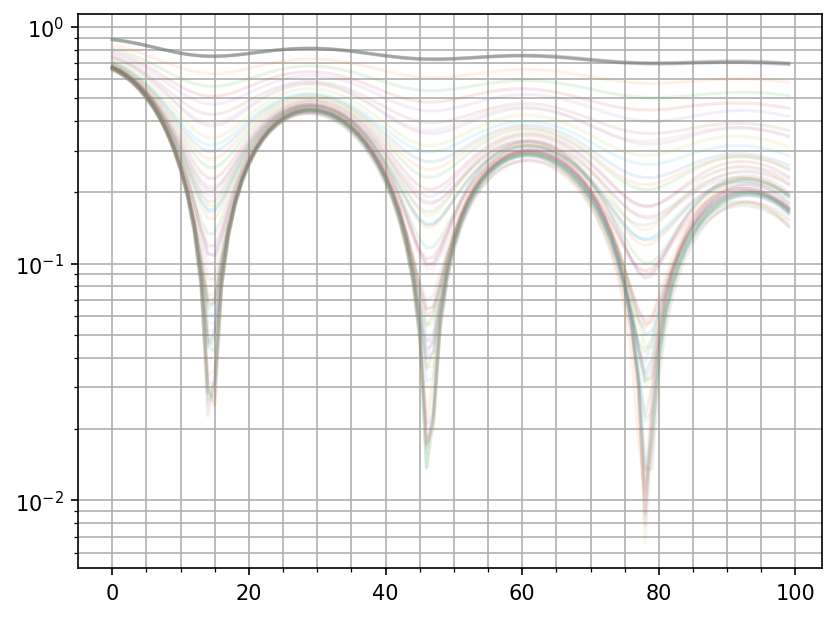

In [123]:
for ac in acs:
    plt.plot(np.abs(ac)[:100], alpha=0.1)
plt.yscale("log")
plt.minorticks_on()
plt.grid(which="both")

In [115]:
import utils.ACfunctions
import importlib
importlib.reload(utils.ACfunctions)
from utils.ACfunctions import Cv

In [110]:
t = 2000
wide = 1000
a = 0.5*(1/item.a+1/item.b)
ac = get_ac(item, t, wide)
T = (get_subdf(df, t,wide)["beta_MLE"].values**-1).mean()
O = get_subdf(df, t,wide)["omega_MLE"].values.mean()

In [96]:
vs = item.history["vs"][3000:25000]

In [109]:
(vs**2).mean(axis=(0,2))

array([0.44080716, 0.44267664, 0.11667522])

In [111]:
T*a**2/(a**2-O**2)

0.4399742209574944

In [108]:
ac[0]/2

(0.441775308023338+0j)

In [77]:
ts = np.arange(len(ac)) * dt

In [74]:
T, O

(0.1173028163517594, 0.42819145820984594)

In [76]:
tzz

2000

(0.0, 100.0)

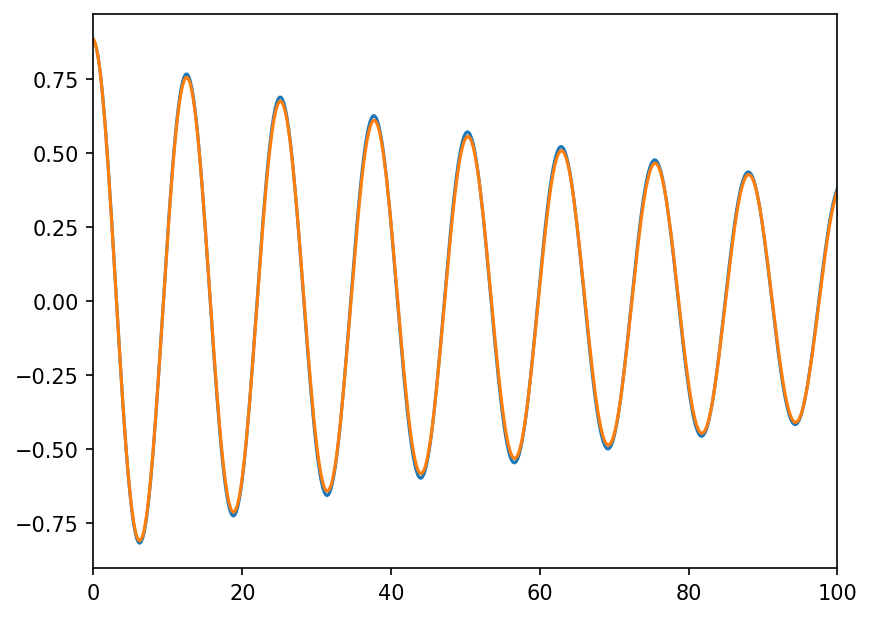

In [117]:
ac_theo = Cv(ts, 0.1, T, O,a)
plt.plot(ts, np.real(ac_theo))
plt.plot(ts, np.real(ac))
plt.xlim([0,100])

In [72]:
ac.shape

(5001,)

/home/ashmat/miniconda3-vesta/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


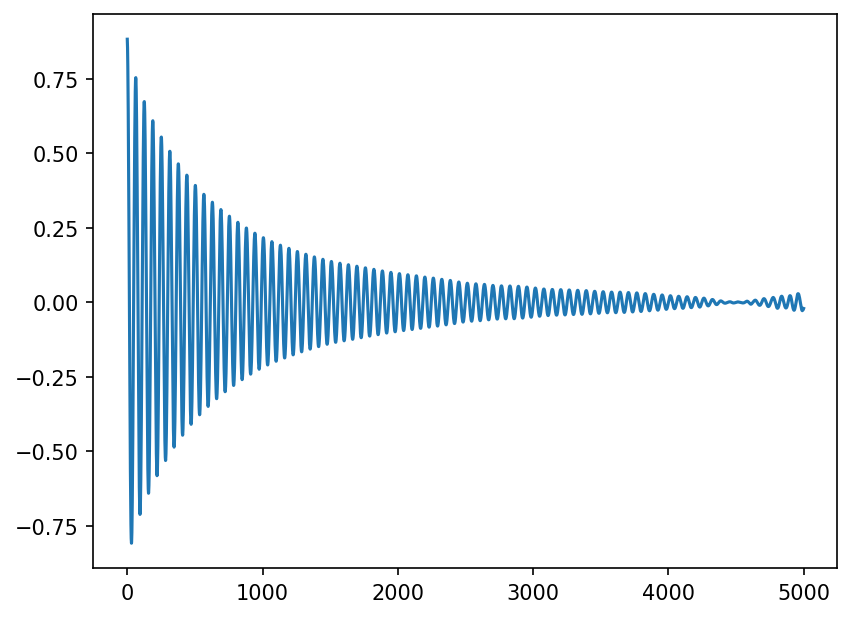

In [71]:
plt.plot(ac)

In [ ]:
def get_gamma(gp_name, W):

    data = np.stack([items[i].history["ac_vc_relative"].mean(axis=0) for i in ids])

    O = np.mean([items[i].history["Omega"] for i in ids])
    T = np.mean([items[i].history["Temp"] for i in ids])

    data = (data)[:,:W]

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)/np.sqrt(len(data))
    ts = np.arange(len(mean))*dt
    
    def f(gamma, W):
        if gamma < 0.0001:
            return np.inf

    #     W = 200
        c = Cr(ts[:W], gamma, T, O)
        c1 = mean[:W]
        d = c-c1
        return np.real(d.dot(d.conj())) / len(d)
    
    optres = scipy.optimize.minimize(f, 1, args=(W,))
    return {"crit": optres.fun, "gamma": optres.x[0]}
    
    

In [ ]:

data = np.stack([items[i].history["ac_relative"] for i in ids])

O = np.mean([items[i].history["Omega"] for i in ids])
T = np.mean([items[i].history["Temp"] for i in ids])

data = (data)[:,:500]

mean = np.mean(data, axis=0)
# std = np.std(data, axis=0)/np.sqrt(len(data))
ts = np.arange(len(mean))*dt

plt.plot(ts, np.abs(mean), color="blue")
gamma = 1.6

plt.plot(ts, np.abs(Cr(ts, gamma=gamma, T =T, O=O )), color="black", ls="--")

plt.yscale("log")
plt.plot()
plt.grid()
